In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Conditioned on the mode sequence, one may partition the observations into K different linear regression problems, where $K = \vert \{ z_1, \dots, z_T \} \vert$. So for each model $k$, we form a matrix $Y^{(k)}$, with $N_k$ columns consisting of the observations $y_t$ with $z_t = k$. Then, 
$$
Y^{(k)} = A^{(k)}\bar{Y}^{(k)} + E^{(k)}
$$
where $A^{(k)} = [A^{(k)}_1 \dots A^{(k)}_r$, $\bar{Y}^{(k)}$ is a matrix of lagged  observations and E is the associated noise vectors.

In [2]:
A = np.array([[1,2],[3,4]])
B = np.array([[1,0,4],[0,4,0],[1,1,1]])
np.kron(A,B)

array([[ 1,  0,  4,  2,  0,  8],
       [ 0,  4,  0,  0,  8,  0],
       [ 1,  1,  1,  2,  2,  2],
       [ 3,  0, 12,  4,  0, 16],
       [ 0, 12,  0,  0, 16,  0],
       [ 3,  3,  3,  4,  4,  4]])

# Use Gharamani-Hinton as first test

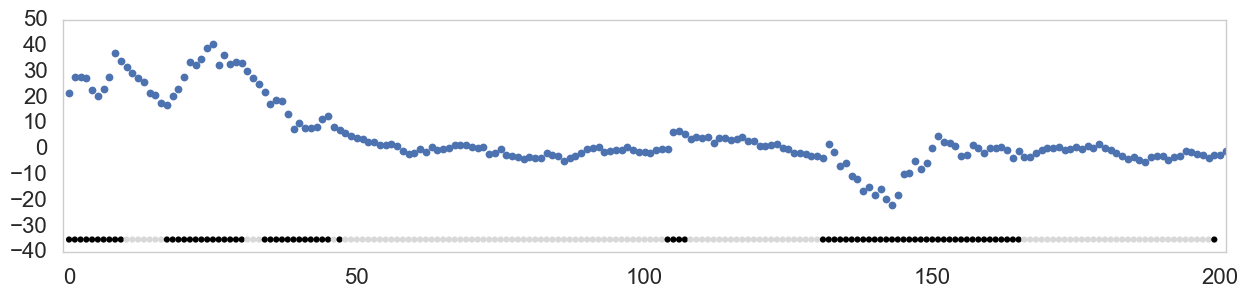

In [3]:
x1 = lambda x: 0.99*x + np.random.normal(0,np.sqrt(10))
x2 = lambda x: 0.9*x + np.random.normal(0,np.sqrt(1))
X = [x1, x2]

def generate_chain():
    ys = [np.random.normal(20,5)]
    
    chains = []
    chain = np.random.choice([0,1], p=[0.5,0.5])
    chains.append(chain)
    
    ys.append(X[chain](ys[-1]))

    for i in range(200):
        if np.random.uniform(0,1) < 0.05:
            if chain == 0:
                chain = 1
            else:
                chain = 0
        chains.append(chain)
        
        ys.append(X[chain](ys[-1]))
    return (np.array(chains), np.array(ys))

chains, ys = generate_chain()

fig, ax = plt.subplots(figsize=(15,3))
temp = np.arange(0,200,1)

c=['black','#d8d8d8']

plt.scatter(temp, -35*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(ys, lw=0, marker='.')
plt.xlim([-1,201])
plt.grid(False)

# Successively test each of the steps for the HDP-AR model

In [117]:
import hdp_scripts
import imp
import time
imp.reload(hdp_scripts)

<module 'hdp_scripts' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py'>

In [190]:
params = {}

# define L=15 components:
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
# params['pi'] = np.array([[0.95,0.05],[0.05,0.95]])
params['theta'] = [{'A': np.random.normal(1,1), 'sigma': 10} for i in range(L)]
# params['theta'] = [{'A': 0.9, 'sigma': np.sqrt(10)}, {'A': 0.99, 'sigma': np.sqrt(1)}]
params['L'] = L
params['Y'] = ys
params['T'] = len(ys)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 100
params['gamma'] = 1
params['priors'] = {
    'M': 1*np.ones(shape=(D,D)),
    'K': 10*np.eye(D)
}

In [191]:
params['pi']

array([[0.0794354 , 0.1643747 , 0.07954107, 0.04395161, 0.12253766,
        0.13190722, 0.26863979, 0.00845284, 0.01101136, 0.09014835],
       [0.03031785, 0.17206045, 0.19560243, 0.06639098, 0.07063237,
        0.02688388, 0.01724462, 0.04729084, 0.24066504, 0.13291152],
       [0.11427202, 0.17899467, 0.0349836 , 0.26184579, 0.08765357,
        0.02350658, 0.08572744, 0.02901877, 0.01231913, 0.17167842],
       [0.0832337 , 0.00493274, 0.11891486, 0.07048988, 0.17867102,
        0.1331197 , 0.21310582, 0.05436749, 0.04523152, 0.09793326],
       [0.06607508, 0.20348005, 0.08835592, 0.04677051, 0.1477787 ,
        0.0563658 , 0.11114693, 0.01335765, 0.1473986 , 0.11927076],
       [0.06503917, 0.1567139 , 0.03703599, 0.13481874, 0.02054719,
        0.09897528, 0.20712666, 0.04342752, 0.01533108, 0.22098446],
       [0.06720016, 0.04058402, 0.11342082, 0.01323515, 0.56827548,
        0.03121182, 0.0148558 , 0.00284882, 0.01956078, 0.12880714],
       [0.07034942, 0.12665096, 0.1049312

Backward messages:

In [192]:
back_messages = hdp_scripts.backward_algorithm_slds(ys, params)

Forward messages:

In [193]:
fwd_pass = hdp_scripts.state_assignments_slds(ys, back_messages, params)
fwd_pass['z']

array([1, 1, 9, 1, 1, 6, 4, 4, 4, 1, 8, 9, 9, 4, 4, 8, 9, 1, 8, 9, 1, 4,
       8, 8, 9, 1, 1, 8, 4, 4, 1, 1, 1, 4, 6, 1, 4, 4, 4, 1, 8, 4, 6, 4,
       4, 1, 9, 6, 4, 8, 0, 5, 5, 5, 9, 2, 6, 4, 1, 3, 5, 9, 3, 4, 2, 9,
       2, 9, 1, 2, 1, 1, 2, 4, 0, 1, 1, 9, 5, 9, 1, 1, 2, 1, 8, 7, 9, 1,
       8, 4, 6, 4, 5, 9, 5, 2, 5, 1, 9, 1, 8, 7, 3, 7, 7, 2, 4, 9, 2, 3,
       6, 4, 3, 6, 4, 8, 4, 1, 9, 3, 4, 8, 9, 5, 3, 2, 9, 6, 2, 7, 4, 1,
       1, 6, 5, 6, 4, 9, 1, 4, 8, 6, 4, 4, 1, 1, 1, 3, 7, 1, 8, 7, 9, 7,
       9, 2, 3, 6, 4, 1, 3, 0, 6, 2, 9, 5, 6, 9, 5, 3, 0, 1, 2, 6, 4, 8,
       5, 9, 3, 4, 9, 2, 0, 4, 9, 5, 1, 1, 9, 2, 3, 6, 4, 4, 1, 4, 3, 5,
       1, 2, 1, 1], dtype=int16)

In [194]:
Y_bar = ys
S_ybarybar, S_yybar, S_yy = hdp_scripts.slds_sufficient_statistics(ys, Y_bar, fwd_pass, params)

In [195]:
Y_bar = np.zeros_like(ys)
Y_bar[1] = ys[1]
Y_bar[1:] = ys[0:-1]

In [196]:
z, Yk, n = fwd_pass['z'], fwd_pass['Yk'], fwd_pass['n']
n

array([[ 0,  2,  0,  0,  1,  1,  1,  0,  0,  0],
       [ 0, 13,  5,  3,  5,  0,  2,  0,  8,  6],
       [ 1,  3,  0,  3,  2,  1,  2,  1,  0,  4],
       [ 2,  0,  1,  0,  3,  2,  4,  2,  0,  0],
       [ 1, 11,  1,  2,  9,  1,  3,  0,  7,  4],
       [ 0,  3,  1,  2,  0,  2,  2,  0,  0,  5],
       [ 0,  1,  2,  0, 12,  1,  0,  0,  0,  1],
       [ 0,  1,  1,  1,  1,  0,  0,  1,  0,  3],
       [ 1,  0,  0,  0,  4,  1,  1,  3,  1,  5],
       [ 0,  9,  6,  3,  1,  6,  2,  1,  0,  1]], dtype=int16)

In [197]:
step3_update = hdp_scripts.step_3(fwd_pass, params)
mbar = step3_update['mbar']
beta = hdp_scripts.update_beta(mbar, params)

In [198]:
priors = [np.eye(1), 1]
pi_theta = hdp_scripts.update_slds_regime_params(n, S_ybarybar, S_yybar, S_yy, params, priors=priors)

# Let's see how it does:

In [199]:
num_iter = 100
z = np.zeros_like(ys)

for i in range(num_iter):
    start = time.time()
    params, res = hdp_scripts.Gibbs_for_HDP_AR(ys, params, priors=[1*np.eye(1), 10])
#     seq2_updated, sorted_thetas, hamming_val = get_hamming_distance(seq1=zis, seq2=res)
    z = res
    if i % 10 == 0:
        print("Iteration: %i, time: %0.2f"%(i, time.time() - start))

Iteration: 0, time: 0.48
Iteration: 10, time: 0.44
Iteration: 20, time: 0.46
Iteration: 30, time: 0.43
Iteration: 40, time: 0.45
Iteration: 50, time: 0.44
Iteration: 60, time: 0.46
Iteration: 70, time: 0.48
Iteration: 80, time: 0.43
Iteration: 90, time: 0.43


In [200]:
res

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int16)

In [201]:
close_look = 0
params['theta'], params['pi']

([{'A': 0.8600484021379989, 'sigma': 1.0969171390371064},
  {'A': 0.19534791852258815, 'sigma': 0.2832742866883152},
  {'A': 2.190721862807048, 'sigma': 0.2862805892183139},
  {'A': 2.1691995038606984, 'sigma': 0.42515226244177257},
  {'A': 0.7781469764957335, 'sigma': 0.5107803084769708},
  {'A': 2.8478728561718816, 'sigma': 0.22457831916883775},
  {'A': 1.3697901629976408, 'sigma': 0.39979117636074346},
  {'A': 3.262402396590072, 'sigma': 0.29343184380181936},
  {'A': 0.9894683571791147, 'sigma': 3.315220526862172},
  {'A': 0.516237824806321, 'sigma': 0.35668513846349365}],
 array([[9.80451965e-001, 0.00000000e+000, 1.14681096e-023,
         1.58112506e-170, 2.06118538e-003, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 1.74868495e-002,
         0.00000000e+000],
        [0.00000000e+000, 9.69271413e-001, 1.17622395e-005,
         3.80043791e-008, 1.41673147e-003, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 2.93000551e-002,
         0.00000000e+000],
   

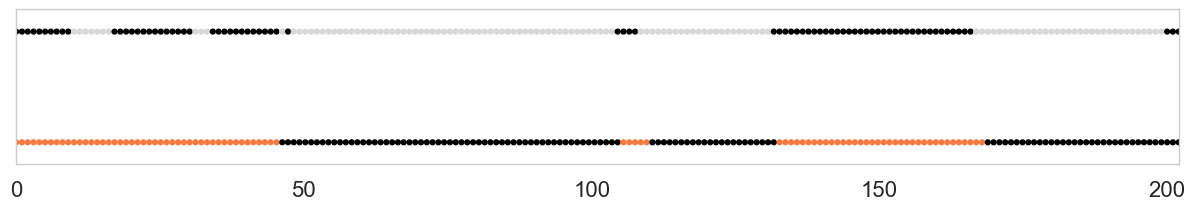

In [202]:
# plt.scatter(np.linspace(0,len(z),num=len(z)), 1*np.ones_like(z), c=[c[i] for i in fwd_pass['z']], lw=0)
# plt.scatter(np.linspace(0,len(z),num=len(z)), 1.25*np.ones_like(z), c=[c[i] for i in np.argmax(back_messages, axis=1)], lw=0)
c=['black','#d8d8d8', 'r', 'g', 'b', 'y', '#42e5f4', '#42e5f4', '#f47a41', '#f47a41']

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(z),num=len(z)), 1.5*np.ones_like(z), c=[c[i] for i in res], lw=0)

plt.xlim([0,len(z)])

plt.scatter(np.linspace(0,len(z),num=len(z)), 2*np.ones_like(z), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(z)])

plt.yticks([])
plt.grid(False)